# BPL_TEST2_Batch_calibration - demo

This notebook shows the possibilities for calibration of the model BPL_TEST2_Batch using scipy.optimize.minimize() routine. There are several different methods to choose between.

The text-book model of batch cultivation we simulate is the following where $S$ is substrate, $X$ is cell concentration, and $V$ is volume of the broth

$$
\eqalign{
{d(VS) \over dt} =& -q_S(S) \cdot VX \cr 
{d(VX) \over dt} =& \mu(S) \cdot VX }
$$

and where specific cell growth rate $\mu$ and substrate uptake rate $q_S$ are

$$
\mu(S) = Y \cdot q_S(S)
$$

$$
q_S(S) = q_S^{max} {S \over K_s + S}
$$

where $Y$ is the yield, $q_S^{max}$ is the maximal specific substrate uptake rate and $K_s$ is the corresponding saturation constant.

The parameter estimation is done with optimization methods that only require evaluation of the missmatch between simulation with given parameters and data. At start the allowed range for each parameter is given. The method used for optimization is SLQSP but can easily be changed [1].

In the near future the FMU may provide first derivative gradient informaion, that will make it possible to choose corresponding method of minimize() for improved performance. This possibility is related to the upgrade to the FMI-standard ver 3.0 for the Modelica compiler.  

The Python package PyFMI [2] that is the base for FMU-explore has a simplified built-in
functionality for parameter estimation that also use scipy.optimize.minimize(). However, there is estimated and the purpose seems to only address smaller examples. Therefore we here define a no possibility to include parameter changes to the compiled model that should not be
Python function evaluation() that facilitate the formulation of the parameter estimation and
bring flexibility to choice of optimization method.

In [1]:
run -i BPL_TEST2_Batch_explore.py

Linux - run FMU pre-comiled JModelica 2.4

Model for bioreactor has been setup. Key commands:
 - par()       - change of parameters and initial values
 - init()      - change initial values only
 - simu()      - simulate and plot
 - newplot()   - make a new plot
 - show()      - show plot from previous simulation
 - disp()      - display parameters and initial values from the last simulation
 - describe()  - describe culture, broth, parameters, variables with values / units

Note that both disp() and describe() takes values from the last simulation

Brief information about a command by help(), eg help(simu)
Key system information is listed with the command system_info()


In [2]:
# Adjust the size of diagrams
plt.rcParams['figure.figsize'] = [15/2.54, 12/2.54]

## Generate data later used for parameter estimation

In [3]:
import pandas as pd

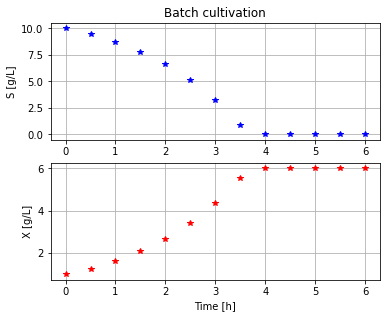

In [4]:
# Data generated
culture_time = 6.0
par(Y=0.50, qSmax=1.0, Ks=0.1)
init(V_0=1.0, VS_0=10, VX_0=1.0)
newplot(plotType='Demo_2')
opts['ncp'] = 12
simu(culture_time)

In [5]:
# Store data in a DataFrame for later use
data = pd.DataFrame(data={'time':sim_res['time'], 'X':sim_res['bioreactor.c[1]'], 'S':sim_res['bioreactor.c[2]']})
data

,time,X,S
0,0.0,1.000000,1.000000e+01
1,0.5,1.280773,9.438453e+00
2,1.0,1.640079,8.719842e+00
3,1.5,2.099615,7.800770e+00
4,2.0,2.686770,6.626459e+00
5,2.5,3.435479,5.129043e+00
6,3.0,4.385325,3.229350e+00
7,3.5,5.559252,8.814967e-01
8,4.0,6.000000,1.048673e-08
9,4.5,6.000000,-6.547559e-11


In [6]:
data.to_excel('data_batch.xlsx')

## Alternatively read data from your own excel-file

Alternatively we can choose to use data from an excel-file - do you prefer that?

In [7]:
xlsx_file = pd.ExcelFile('data_batch_2.xlsx')
table = xlsx_file.parse('Sheet1')
table

,time,X,S
0,0.00,0.40,20.50
1,0.67,0.63,20.16
2,2.83,1.50,17.94
3,4.11,2.63,14.71
4,5.50,4.44,9.88
5,6.42,6.93,2.45
6,6.93,8.47,0.00
7,7.50,8.47,0.00
8,8.00,8.47,0.00


data = table

In [8]:
# The initial values you may need to change to fit your data - use the function init()
disp('_0')

V_0 : 1.0
VX_0 : 1.0
VS_0 : 10.0


# Change initial conditions for batch_data_2
init(V_0=1.0, VX_0=0.40, VS_0=20.5)
culture_time = 8.0

Remember to adjust the parBounds below appropriate for your data

## Simulation with initial guess of parameters compared with data

Here we define the parameters that should be estimated and specify allowed ranges. 
Nominal parameters are chosen as the mid-point of the allowed parameter range. 

Simulation with these nominal parameter set and compare with data give an idea of who well the model fit data.

In [9]:
# Parameters to be estimated using parDict names and their bounds
parEstim = ['Y', 'qSmax', 'Ks']
parBounds = [(0.3, 0.7), (0.7, 1.3), (0.05, 0.20)]
parEstim_0 = [np.mean(parBounds[k]) for k in range(len(parBounds))]

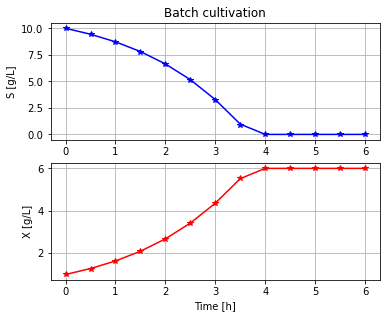

In [10]:
# Simulation with nominal parameters
newplot(plotType='Demo_1')
par(Y=parEstim_0[0], qSmax=parEstim_0[1], Ks=parEstim_0[2])
simu(culture_time)

# Show data
ax1.plot(data['time'], data['S'],'b*')
ax2.plot(data['time'], data['X'],'r*')
plt.show()

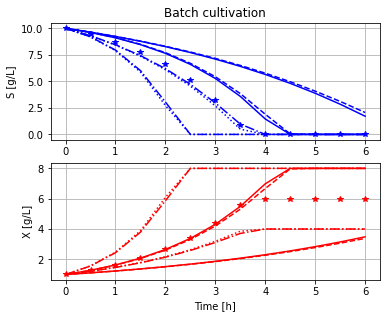

In [11]:
# Simulation over the parameter ranges given
newplot(plotType='Demo_1')
for Y_value in parBounds [0]:
    for qSmax_value in parBounds[1]:
        for Ks_value in parBounds[2]:
            par(Y=Y_value, qSmax=qSmax_value, Ks=Ks_value)
            simu(culture_time)
            
# Show data
ax1.plot(data['time'], data['S'],'b*')
ax2.plot(data['time'], data['X'],'r*')
plt.show()

Simulation over the diferent parameter combinations of the parameter bounds shows that data is "covered" and it should be possible to find a parameter combination that describes the data well. 

## Parameter estimation

Here we use the scipy.optimize.minimize() procedure which contain a family of different methods [1].
Since we has chosen to work with bounds on the parameters to be estimated there are only three methods to choose between. Here the method Sequential Least SQuares Programming SLSQP is chosen.


In [12]:
# For clarity of code here we import again
import scipy.optimize

In [13]:
# Parameters to be estimated using parDict names and their bounds
extra_args = (parEstim, data, fmu_model , parDict, parLocation)

In [14]:
# Modified evaluation function tailored for Python optimization algorithms
def evaluation(x, parEstim, data=data, fmu_model=fmu_model, 
                parDict=parDict, parLocation=parLocation):
    """The parameter list is tailored for scipy optimization algorithms interface, 
       where the first parameter x is an array with parameters that are tuned 
       and evalauted."""
      
    # Load model
    global model
    if model is None:
        model = load_fmu(fmu_model)
    model.reset()
   
    # Change parameters and initial values from default
    for i, p in enumerate(parEstim): model.set(parLocation[p], x[i])
    for p in set(parDict)-set(parEstim): model.set(parLocation[p], parDict[p])
      
    # Simulation options
    opts = model.simulate_options()
    opts['ncp'] = 12
    opts['result_handling'] = 'memory'
    opts['silent_mode'] = True
   
    # Simulate
    sim_res = model.simulate(start_time=0.0, final_time=culture_time, options=opts)
   
    # Calculate loss function V
    V={}
    V['X'] = np.linalg.norm(data['X'] - np.interp(data['time'], sim_res['time'], sim_res['bioreactor.c[1]']))
    V['S'] = np.linalg.norm(data['S'] - np.interp(data['time'], sim_res['time'], sim_res['bioreactor.c[2]']))
  
    return V['X'] + V['S']

In [15]:
import time

In [16]:
# Run minimize()
start_time = time.time()
result = scipy.optimize.minimize(evaluation, x0=parEstim_0, args=extra_args, 
                                 method='SLSQP', bounds=parBounds, options={"disp":True})
print('CPU-time =', time.time()-start_time)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.436178655884325e-05
            Iterations: 16
            Function evaluations: 101
            Gradient evaluations: 16
CPU-time = 0.2756948471069336


In [17]:
result

     fun: 3.436178655884325e-05
     jac: array([  37.26864631, -439.63743317, -439.60416264])
 message: 'Optimization terminated successfully'
    nfev: 101
     nit: 16
    njev: 16
  status: 0
 success: True
       x: array([0.50000102, 0.99999725, 0.09999004])

The estimated parameters x are very close to the original values and no surprise.

Test of the three methods available that handle parameter bounds: TNC, L-BFGS-B and SLSQP. It turns out that SLSQP is by far the fastest. It is 3 times faster than L-BFGS-B which is faster than TNC. Can be that SLSQP is less robust though. The nit (number of iterations does not differ that much though: 24 vs 30. The nfev (number of function evaluations) is perhaps more important 127 vs 256. A more precise timer function is likely timeit for this short times.

The Nelder-Mead algorithm has a good reputation to be very robust, but more slow,  and with this method we cannot have bounds on the parameters.

## Simulation with estimated parameters compared with data

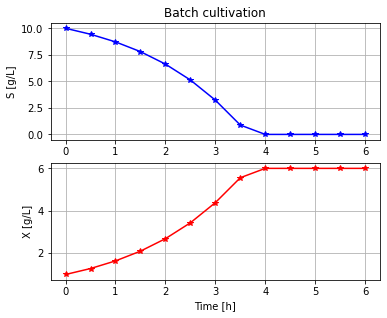

In [18]:
newplot(plotType='Demo_1')
par(Y=result.x[0], qSmax=result.x[1], Ks=result.x[2])
simu(culture_time)

# Show data
ax1.plot(data['time'], data['S'],'b*')
ax2.plot(data['time'], data['X'],'r*')
plt.show()

## Analysis of the loss function

* Contour plot of simplified version V(Y, qSmax)
* One or several minima?
* Shape, elongated?
* Ortogonality of chosen parameters, compare with V(Y, mu_max)

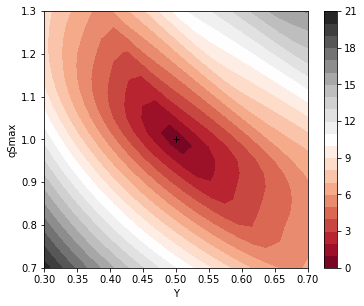

In [19]:
# Sweep through Y and qSmax variation and store the value of the loss-function for each
nY = 20
nqSmax = 20
V = np.zeros((nY, nqSmax))
             
Y = np.linspace(parBounds[0][0],parBounds[0][1],nY)
qSmax = np.linspace(parBounds[1][0],parBounds[1][1],nqSmax)

for j in range(nY):
    for k in range(nqSmax):
        V[j,k] = evaluation([Y[j], qSmax[k], 0.1], parEstim)

# Contour plot
plt.figure()
plt.subplot(1,1,1)
plt.contourf(Y, qSmax, V, 20, cmap='RdGy')
plt.plot(result.x[0], result.x[1],'k+')
plt.colorbar()
plt.ylabel('qSmax')
plt.xlabel('Y')
plt.show()

We see
* Unique mimima
* Narrow valley
* Valley about - 45 degree

Change variables to mu_max = Y*qSmax vs qSmax

## Summary

A choice was made to work with allowed ranges of parameters to be estimated and a start value was defined as the center point in this parameter space.

An evaluation() function was created that define how the difference beween simulation and data is measured. The function is rather transparent and easy to modify and you may want to change weight on the loss in S and X for instance. Here they have equal weight. 

The FMU-explore workspace dictionaries partDict[] and parLocation[] are useful also here and simplify the code.

The call optimize.minimize() has several parameters and can easily be modified, for instance change of method.

The estimated parameters were close to perfect!

## References

[1] Scipy Reference guide on optimize.minimize()
[here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html?highlight=minimize)

[2] Andersson, C., Åkesson, J., Fuhrer C. : "PyFMI: A Python package for simulation of coupled dynamic models with the functional mock-up interface", Centre for Mathematical Sciences, Lund University, Report LUTFNA-5008, 2016. 

## Appendix

In [20]:
describe('parts')

['bioreactor', 'bioreactor.culture', 'liquidphase', 'MSL']


In [21]:
describe('MSL')

MSL: 3.2.2 build 3 - used components:  


In [22]:
system_info()


System information
 -OS: Linux
 -Python: 3.8.2
 -PyFMI: 2.7.4
 -FMU by: JModelica.org
 -FMI: 2.0
 -Type: FMUModelCS2
 -Name: BPL_TEST2.Batch
 -Generated: 2022-09-19T14:20:20
 -MSL: 3.2.2 build 3
 -Description: Bioprocess Library version 2.1.0 beta
 -Interaction: FMU-explore ver 0.9.3


# BPL_TEST2_Batch_calibration
Material of standard text book model of batch cultivation where the model is calibrated using time series data for substrate and cell concentration. It is possible to upload your own batch data and calibrate the model for your data!

A bioprocess model need to be calibrated by estimating key process parameters. The model here has only three parameters $Y$, $qSmax$ and $Ks$, but the last parameter has little influence. The intial values $V_0$, $VX_0$ and $VS_0$ are given.

We use here methods that only need evaluation of the loss function for each tested parameter setting, thus does not use derivative information. These methods are collected in Python Scipy-package in the function scipy.optimize.minimize() and it is easy to change method and adjust parameters of the algorithm. The advantage with these methods is that you can easilty address more complex models with har non-linearities and more parameters. The drawback is that optimization is more time consuming than methods that use derivative information. 

In Figure 1 below we see the results of fitting the model to simulated data and works perfectly well. Here parameters were given with min- and max-bounds. There are fewer methods that use bounds on parameters. Here we choose to work with SLSQP since it gave fasd and good convergence.

![](Fig_1_Batch_simu_data.png)

In Figure 2 we see the contour plot of the loss function, simplified by keeping the Ks-parameter value constant. Clearly there is a unique minima for the range of parameters considered. Further the contours has an ellipsoid-shape and narrow 

![](Fig_2_Batch_loss_function_contour.png)


License information:
* The binary-file with extension FMU is shared under the permissive MIT-license
* The other files are shared under the GPL 3.0 license